In [1]:
import argparse
import torch
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset_builder, load_dataset, load_from_disk
from torch.utils.data import Dataset, DataLoader
import os
import json
from tensorboardX import SummaryWriter
from tqdm.notebook import tqdm
import random
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import time
import difflib


from finetune import CloneDetector

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Functions

In [2]:
def find_threshold(scores, labels, metric='f1'):
    # metric: 'acc' or 'f1'

    for label in labels:
        assert abs(label - 1) < 1e-10 or abs(label) < 1e-10
    assert metric in ['acc', 'f1']

    arr = sorted(list(zip(scores, labels)), key=lambda x: x[0])

    pre = 0.0
    post = sum(labels)

    max_eval, best_threshold = 0.0, arr[0][0]
    for i in range(len(arr) - 1):
        pre += arr[i][1]
        post -= arr[i][1]

        tp = post
        fp = len(arr) - i - post
        fn = pre
        tn = (i-pre)

        acc = (tp + tn) / len(arr)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * precision * recall / (precision + recall)

        eval = {'acc': acc, 'f1': f1}

        if max_eval < eval[metric]:
            max_eval = acc
            best_threshold = (arr[i][0] + arr[i][1]) / 2
    return best_threshold

def accuracy(scores, labels, threshold):
    return np.mean(((scores > threshold).astype(np.int32) == labels).astype(np.float32)).tolist()


def f1_score(scores, labels, threshold):
    return metrics.f1_score((scores > threshold), labels)

def sumCounter(counter):
    return sum(counter.values())

    
class AugmentedDataset(Dataset):
    def __init__(self, inputs):
        self.data = inputs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    


# Load Model

In [3]:
%%time


model_name = "microsoft/codebert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
batch_size = 8

def tokenize(code):
    return tokenizer(code, return_tensors="pt", truncation=True, padding="longest", max_length=512)

def collate_fn(items):
    x = {}

    code1, code2, labels = [], [], []
    for item in items:
        code1.append(item['code1'])
        code2.append(item['code2'])
        labels.append(item['similar'])

    x['code1'] = tokenize(code1)
    x['code2'] = tokenize(code2)
    x['labels'] = torch.tensor(labels, dtype=torch.float32)

    return x

ckpt_path = '/mnt/hdd/696ds/tasks/clone_detection/codebert/ckpt/0327_codebert-base_lr3.0e-07-w5000/step1000000.pt'
# model = CloneDetector(model_name, device)
model = torch.load(ckpt_path).to(device)
model.device = device
model.train(False)

CPU times: user 1.74 s, sys: 888 ms, total: 2.63 s
Wall time: 2.71 s


CloneDetector(
  (model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,

# Find threshold using val data from a different fold (fold 5/5)

In [4]:
%%time
batch_size = 8
n_th = 30000

# dataset = load_from_disk("/mnt/ssd/696ds_data/PoolC/original/1-fold-clone-detection-600k-5fold")["val"]
dataset = load_dataset("PoolC/1-fold-clone-detection-600k-5fold", split="val")
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

Found cached dataset parquet (/home/dlim/.cache/huggingface/datasets/PoolC___parquet/snoop2head--1-fold-clone-detection-600k-5fold-57d7a53828ee0494/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


CPU times: user 144 ms, sys: 48.1 ms, total: 192 ms
Wall time: 683 ms


In [5]:
%%time
scores_list, labels_list = [], []
pbar = tqdm(dataloader, total=(n_th+batch_size-1) // batch_size)
for i, batch in enumerate(pbar):
        
    if batch_size * i >= n_th:
        break
    
    labels = batch['labels']
    
    scores = model(batch).to('cpu')
    
    scores, labels = scores.tolist(), labels.tolist()
    
    scores_list += scores if type(scores) == list else [scores]
    labels_list += labels if type(labels) == list else [labels]
    
scores, labels = np.array(scores_list), np.array(labels_list)
threshold = find_threshold(scores, labels)
acc, f1 = accuracy(scores, labels, threshold), f1_score(scores, labels, threshold)
print(threshold)

  0%|          | 0/3750 [00:00<?, ?it/s]

0.7097582221031189
CPU times: user 7min, sys: 25.7 s, total: 7min 25s
Wall time: 5min 34s


/tmp/ipykernel_983832/3185505362.py:26: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * precision * recall / (precision + recall)


In [6]:
# threshold = 0.7560033202171326

# Read Augmented Dataset

In [7]:
os.listdir("/mnt/ssd/696ds_data/PoolC/1-fold-clone-detection-600k-5fold/val")

['050123']

In [8]:
%%time
save_dir = "/mnt/ssd/696ds_data/PoolC/1-fold-clone-detection-600k-5fold/val/050123/"
print(os.listdir(save_dir))
save_path = os.path.join(save_dir, "augmented__p0.1_p0.2_p0.3_p0.4_p0.5_p0.6_p0.7_p0.8_p0.9_p1.0_group.json")

# p2index = {"0.5": 0}

with open(save_path, 'r') as f:
    json_data = json.load(f)
    print(type(json_data))
    
data = json_data['data']



['augmented__p0.1_p0.2_p0.3_p0.4_p0.5_p0.6_p0.7_p0.8_p0.9_p1.0_group.json']
<class 'dict'>
CPU times: user 15.2 s, sys: 2.74 s, total: 18 s
Wall time: 17.8 s


In [9]:
print(data[0]['augmented'][0].keys())

dict_keys(['code1', 'code1_log', 'code2', 'code2_log'])


In [10]:
print(data[0]['augmented'][0]['code1_log'].keys())

dict_keys(['add_whitespace,add_new_lines,add_commas', 'list_comp_to_for,set_comp_to_for,dict_comp_to_for', 'change_variable_names', 'for_to_while,lambda_to_function,combine_statement', 'remove_comments', 'remove_empty_line,remove_whitespace,remove_commas', 'remove_unused_imports'])


In [11]:
print(data[0]['augmented'][0]['code1'].keys())

dict_keys(['add_whitespace,add_new_lines,add_commas', 'list_comp_to_for,set_comp_to_for,dict_comp_to_for', 'change_variable_names', 'for_to_while,lambda_to_function,combine_statement', 'remove_comments', 'remove_empty_line,remove_whitespace,remove_commas', 'remove_unused_imports'])


# Evaluate on the PoolC dataset

In [12]:
def func(datapoints):
        
    dataset = AugmentedDataset(datapoints)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    scores_list = []
    labels_list = []
    for j, batch in enumerate(dataloader):

        labels = batch['labels']
        scores = model(batch).to('cpu')

        labels, scores = labels.tolist(), scores.tolist()
        labels_list += labels if type(labels) == list else [labels]
        scores_list += scores if type(scores) == list else [scores]


    scores = np.array(scores_list)
    labels = np.array(labels_list)
    return np.array(scores_list), np.array(labels_list)

def original_scores(n):
    dataset1 = []
    for i in range(len(data)):
        if len(dataset1) == n:
            break
            
        dataset1.append(
            {
                'code1': data[i]['original']['code1'],
                'code2': data[i]['original']['code2'],
                'similar': data[i]['original']['similar']
            }
        )

    scores1, labels1 = func(dataset1)
    acc1 = accuracy(scores1, labels1, threshold)
    f1_1 = f1_score(scores1, labels1, threshold)
    
    
    results = {
        'Accuracy': acc1,
        'F1': f1_1,
        'Mean': np.mean(scores1),
        'Standard Deviation': np.std(scores1),
        'Same Prediction': 1.0,
        'Mean Absolute Difference': 0.0,
#         'Standard Deviation of Absolute Difference': 0.0,
#         'Root Mean Squared Difference': 0.0
        
    }
    
    return scores1, results
    

def augmented_scores(p, transformation_type, n, scores1):
    index = p2index[p]
    logs = Counter()
    dataset2 = []
    for i in range(len(data)):
        if len(dataset2) == n:
            break
            
        dataset2.append(
            {
                'code1': data[i]['augmented'][p2index[p]]['code1'][transformation_type],
                'code2': data[i]['original']['code2'],
                'similar': data[i]['original']['similar']
            }
        )
        
        for key, value in data[i]['augmented'][p2index[p]]['code1_log'][transformation_type].items():
            logs[key] += value
            
    scores, labels = func(dataset2)

    acc = accuracy(scores, labels, threshold)
    f1 = f1_score(scores, labels, threshold)
    mean_absolute_difference = np.mean(np.abs(scores1-scores))
    
    results = {
        'Accuracy': acc,
        'F1': f1,
        'Mean': np.mean(scores),
        'Standard Deviation': np.std(scores),
        'Same Prediction': np.mean((scores1 > threshold) == (scores > threshold)),
        'Mean Absolute Difference': mean_absolute_difference,
#         'Standard Deviation of Absolute Difference': np.std(abs(scores1-scores) - mean_absolute_difference),
#         'Root Mean Squared Difference': np.sqrt(np.mean((scores1 - scores) ** 2))
    }
    
    diffs = [i for i, same in enumerate((scores1 > threshold) == (scores > threshold)) if not same]
    
    
#     print('p:', p)
#     for key, value in results.items():
#         print(f"{key:<30}: {value:>3.3f}")
#     print()
    return results, logs, diffs, scores


In [13]:
%%time
n_pc = 30000

scores1, results1 = original_scores(n_pc)


CPU times: user 6min 41s, sys: 23.4 s, total: 7min 4s
Wall time: 5min 20s


In [14]:
print(results1)

{'Accuracy': 0.8499141931533813, 'F1': 0.8648972386836464, 'Mean': 1.5553398933681153, 'Standard Deviation': 1.875650460967656, 'Same Prediction': 1.0, 'Mean Absolute Difference': 0.0}


In [15]:
p2index = {f'0.{i+1}': i for i in range(9)}
p2index['1.0'] = 9
transformation_types = list(data[0]['augmented'][0]['code1_log'].keys())

In [16]:
%%time
targets = sorted(list(p2index.keys()), key=lambda x:float(x))
# targets = ['0.2', '0.5', '0.7', '1.0']
results = defaultdict(dict)
logs = defaultdict(dict)
diffs = defaultdict(dict)
scores = defaultdict(dict)
for transformation_type in transformation_types:
    for p in targets:
        results[transformation_type]['0.0'] = results1
        logs[transformation_type]['0.0'] = Counter()
        scores[transformation_type]['0.0'] = scores1
        results[transformation_type][p], logs[transformation_type][p], diffs[transformation_type][p], scores[transformation_type][p] = \
                    augmented_scores(p, transformation_type, n_pc, scores1)

CPU times: user 7h 52min 11s, sys: 27min 12s, total: 8h 19min 24s
Wall time: 6h 17min 59s


In [17]:

targets = ["0.0"] + targets
x = [float(target) for target in targets]


In [18]:
print(transformation_types)

labels = {
    'add_whitespace,add_new_lines,add_commas': 'add whitespaces, new lines, commas',
    'list_comp_to_for,set_comp_to_for,dict_comp_to_for': 'comprehension to for loop',
    'change_variable_names': 'change local variable names',
    'for_to_while,lambda_to_function,combine_statement': 'for loop to while loop, lambda to function, combine statement',
    'remove_comments': 'remove comments',
    'remove_empty_line,remove_whitespace,remove_commas': 'remove empty lines, whitespaces, commas',
    'remove_unused_imports': 'remove unused imports'
}

['add_whitespace,add_new_lines,add_commas', 'list_comp_to_for,set_comp_to_for,dict_comp_to_for', 'change_variable_names', 'for_to_while,lambda_to_function,combine_statement', 'remove_comments', 'remove_empty_line,remove_whitespace,remove_commas', 'remove_unused_imports']


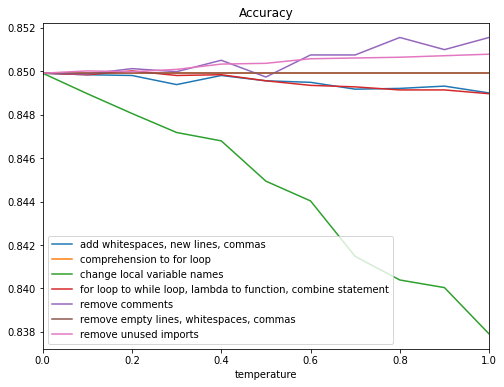

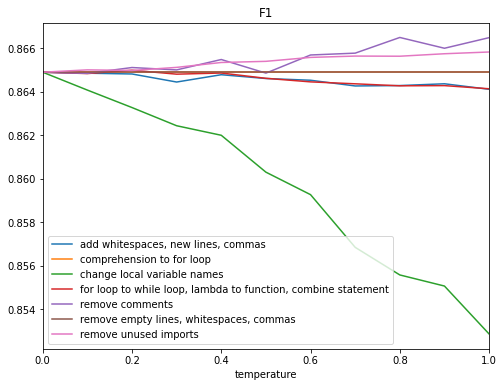

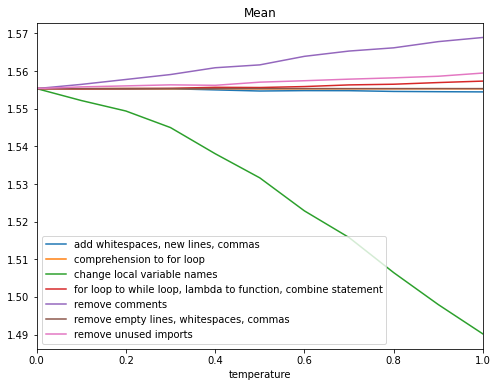

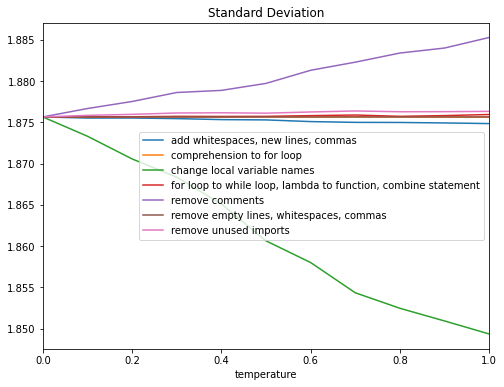

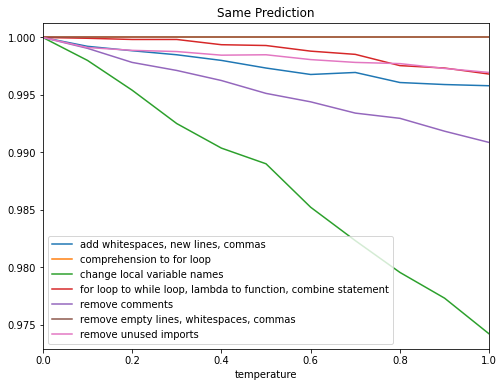

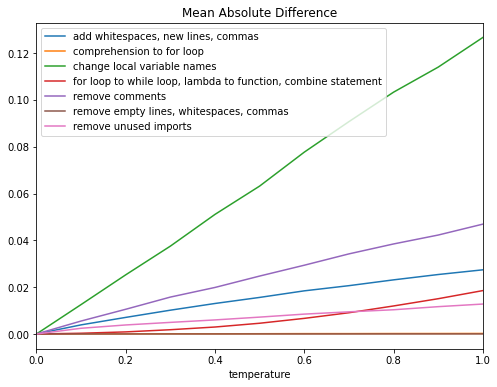

In [19]:
metrics_list = ['Accuracy', 'F1', 'Mean', 'Standard Deviation', 'Same Prediction', 
                'Mean Absolute Difference']
# cm = plt.get_cmap('gist_rainbow')

for metric in metrics_list:
    plt.figure(figsize=(8, 6))
#     ax = fig.add_subplot(111)
    for i, transformation_type in enumerate(transformation_types):
        plt.plot(x, [results[transformation_type][p][metric] for p in targets], label=labels[transformation_type])

    plt.title(metric)
    plt.xlabel('temperature')
    plt.xlim((0.0, 1.0))
    plt.legend()
    plt.show()

# Print results

In [21]:

for p in targets:
    print(f'======================== [p = {p}] ================================')
    for key in logs.keys():
        print(logs[key][p])
        print(sum(logs[key][p].values()))
        print(results[key][p])
        print()

======================== [p = 0.0] ================================
Counter()
0
{'Accuracy': 0.8499141931533813, 'F1': 0.8648972386836464, 'Mean': 1.5553398933681153, 'Standard Deviation': 1.875650460967656, 'Same Prediction': 1.0, 'Mean Absolute Difference': 0.0}

Counter()
0
{'Accuracy': 0.8499141931533813, 'F1': 0.8648972386836464, 'Mean': 1.5553398933681153, 'Standard Deviation': 1.875650460967656, 'Same Prediction': 1.0, 'Mean Absolute Difference': 0.0}

Counter()
0
{'Accuracy': 0.8499141931533813, 'F1': 0.8648972386836464, 'Mean': 1.5553398933681153, 'Standard Deviation': 1.875650460967656, 'Same Prediction': 1.0, 'Mean Absolute Difference': 0.0}

Counter()
0
{'Accuracy': 0.8499141931533813, 'F1': 0.8648972386836464, 'Mean': 1.5553398933681153, 'Standard Deviation': 1.875650460967656, 'Same Prediction': 1.0, 'Mean Absolute Difference': 0.0}

Counter()
0
{'Accuracy': 0.8499141931533813, 'F1': 0.8648972386836464, 'Mean': 1.5553398933681153, 'Standard Deviation': 1.875650460967656, 

# Print cases when the predictions are changed

In [22]:
def print_code_diff(text, code1, code2, code3, similar, show_diff=False, show_codes=True):
    print('==================================================================')
    print(text)
    print('------------------------------------------------------------------')
    if show_diff:
        print(
            "".join(
                difflib.unified_diff(code1.splitlines(1), code2.splitlines(1))
            )
        )
        print('------------------------------------------------------------------')
    if show_codes:
        print(code1)
        print('------------------------------------------------------------------')
        print(code2)
        print('------------------------------------------------------------------')
        print(code3)
        print('------------------------------------------------------------------')
    print(f'similar (original): {similar}')
    print('==================================================================')
    

In [23]:
for p in targets[1:]:
    print(f'############################## [p = {p}] #####################################')
    for key in diffs.keys():
        print(f'%%%%%%%%%%%%%%%%%%%%%% [key = {key}] %%%%%%%%%%%%%%%%%%%%%%%%%%%')
        key = 'change_variable_names'
        item = diffs[key][p]
        size = len(diffs[key][p])
        for i in range(min(3, size)):
            code1 = data[item[i]]['original']['code1']
            code1_augmented = data[item[i]]['augmented'][p2index[p]]['code1'][key]
            similar = data[item[i]]['original']['similar']
            code2 = data[item[i]]['original']['code2']
            print('==================================================================')
            print(f"p={p}, key={key}")
            print('------------------------------------------------------------------')
            print(
                "".join(
                    difflib.unified_diff(code1.splitlines(1), code1_augmented.splitlines(1))
                )
            )
            print('------------------------------------------------------------------')
            print(code1)
            print('------------------------------------------------------------------')
            print(code1_augmented)
            print('------------------------------------------------------------------')
            print(code2)
            print('------------------------------------------------------------------')
            print(f'similar (original): {similar}')
            print(f'original: {scores[transformation_type]["0.0"][item[i]]}, transformed: {scores[transformation_type][p][item[i]]}')
            print('==================================================================')
            
#             print_code_diff(f"p={p}, key={key}", original, augmented, code2, similar, show_diff=True)
            
            time.sleep(0.5)
    

############################## [p = 0.1] #####################################
%%%%%%%%%%%%%%%%%%%%%% [key = add_whitespace,add_new_lines,add_commas] %%%%%%%%%%%%%%%%%%%%%%%%%%%
p=0.1, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -5,13 +5,13 @@
 
 
     B = []
-    flg_m = 0
+    v0 = 0
     flg_p = 0
 
     for a in A:
         if a < 0:
             B.append([abs(a),-1])
-            flg_m = 1
+            v0 = 1
         else:
             B.append([abs(a),1])
             flg_p = 1
@@ -33,14 +33,14 @@
         ans *=-1
         print(ans%MOD)
         exit()
-    elif flg_p * flg_m == 0:
+    elif flg_p * v0 == 0:
         L = B[:k]
         ans = cal_ans(L)
         print(ans)
         exit()
 
     flg_p = 0
-    flg_m = 0
+    v0 = 0
     flg_lm = 0
     flg_lp = 0
     # print(B)
@@ -54,9 +54,9 @@
                 last_p = n
         else:
             if sign == -1:
-                if flg_m == 0:
+                if

In [24]:
p = "1.0"
print(f'############################## [p = {p}] #####################################')
for key in diffs.keys():
    print(f'%%%%%%%%%%%%%%%%%%%%%% [key = {key}] %%%%%%%%%%%%%%%%%%%%%%%%%%%')
    item = diffs[key][p]
    size = len(diffs[key][p])
    for i in range(min(3, size)):
        original = data[item[i]]['original']['code1']
        augmented = data[item[i]]['augmented'][p2index[p]]['code1'][key]
        similar = data[item[i]]['original']['similar']
        code2 = data[item[i]]['original']['code2']
        print_code_diff(f"p={p}, key={key}", original, augmented, code2, similar, show_diff=True)
        time.sleep(0.5)

############################## [p = 1.0] #####################################
%%%%%%%%%%%%%%%%%%%%%% [key = add_whitespace,add_new_lines,add_commas] %%%%%%%%%%%%%%%%%%%%%%%%%%%
p=1.0, key=add_whitespace,add_new_lines,add_commas
------------------------------------------------------------------
--- 
+++ 
@@ -1,2 +1,2 @@
-m, n = map(int, input().split())
+m, n, = map(int, input().split())
 print((m + n - 1)//n)
------------------------------------------------------------------
m, n = map(int, input().split())
print((m + n - 1)//n)
------------------------------------------------------------------
m, n, = map(int, input().split())
print((m + n - 1)//n)
------------------------------------------------------------------
H,A=map(int,input().split())
AP=0
for i in range(10001):
  AP=A*i
  if AP>=H:
    print(i)
    break
------------------------------------------------------------------
similar (original): 1
p=1.0, key=add_whitespace,add_new_lines,add_commas
---------------------------------

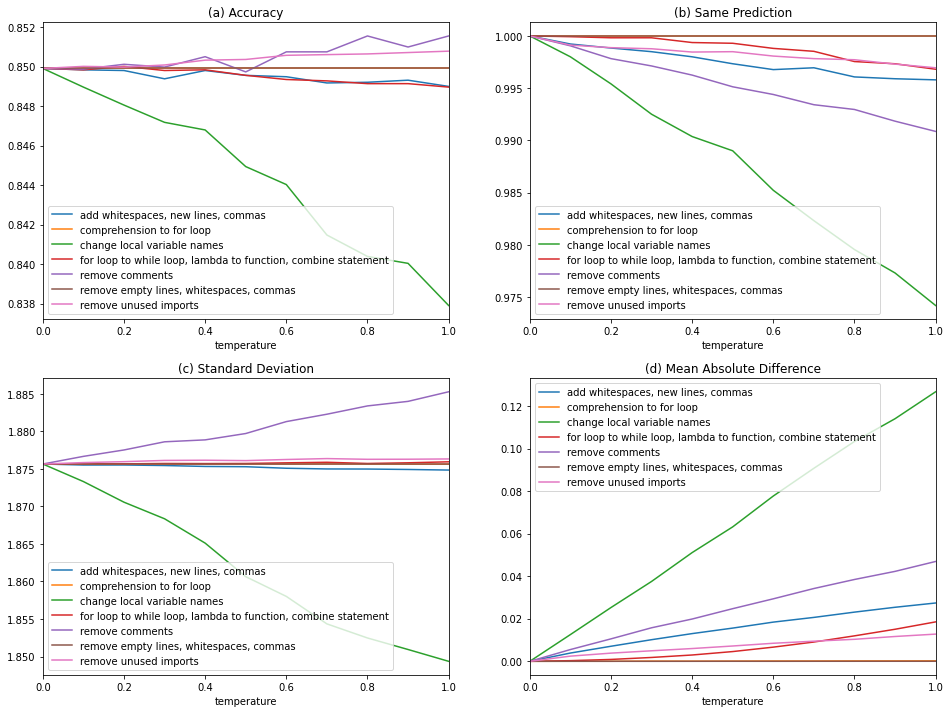

In [25]:

import string
plt.figure(figsize=(16, 12))
for i, metric in enumerate(['Accuracy', 'Same Prediction', 'Standard Deviation', 'Mean Absolute Difference']):
    plt.subplot(2,2,i+1)
#     ax = fig.add_subplot(111)
    for j, transformation_type in enumerate(transformation_types):
        plt.plot(x, [results[transformation_type][p][metric] for p in targets], label=labels[transformation_type])

    plt.title(f"({string.ascii_lowercase[i]}) {metric}")
    plt.xlabel('temperature')
    plt.xlim((0.0, 1.0))
    plt.legend()
plt.savefig('0411_codebert')